## Модели прогнозирования объема убоя КРС по Жамбылской области

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from IPython.display import display
import math
from prophet import Prophet
pd.set_option('display.max_columns', 130)


import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter("ignore", category=InterpolationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Подготовка данных и EDA

In [2]:
df = pd.read_excel("Датасет по КРС.xlsx")
df.sample(10)

,Регион,Период,КРС,Осадки,Поголовье: КРС,Температура
1952,МАНГИСТАУСКАЯ ОБЛАСТЬ,2024-07,100.98,6.4,18717.0,26.658065
2331,СЕВЕРО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,2018-05,2561.11,62.6,449030.0,9.393548
541,ВОСТОЧНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,2020-02,7826.65,60.8,1022237.0,-6.093103
367,АТЫРАУСКАЯ ОБЛАСТЬ,2015-08,1623.48,3.4,165536.0,25.241935
867,ГОРОД АЛМАТЫ,2017-04,NaN,216.7,2950.0,11.190000
753,ГАСТАНА,2017-10,17.02,NaN,NaN,NaN
713,ГАЛМАТЫ,2024-06,2.30,NaN,NaN,NaN
1495,КАРАГАНДИНСКАЯ ОБЛАСТЬ,2016-06,9486.44,62.5,642223.0,17.770000
546,ВОСТОЧНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,2020-07,10335.39,61.8,1277783.0,21.506452
1966,ОБЛАСТЬ АБАЙ,2023-02,2088.83,35.0,28148.0,-11.339286


In [3]:
df_zhambyl = df[df['Регион'] == 'ЖАМБЫЛСКАЯ ОБЛАСТЬ']
df_zhambyl = df_zhambyl.drop('Регион', axis = 'columns')
df_zhambyl.head()

,Период,КРС,Осадки,Поголовье: КРС,Температура
1238,2015-01,2731.22,48.5,303643.0,-2.306452
1239,2015-02,3109.06,25.3,316778.0,1.871429
1240,2015-03,2538.81,36.2,344717.0,3.958065
1241,2015-04,3379.88,25.4,357904.0,14.166667
1242,2015-05,2921.49,16.4,356641.0,20.106452


In [4]:
df_zhambyl = df_zhambyl.rename(columns={'КРС': 'Объем убоя: КРС'})
df_zhambyl.head()

,Период,Объем убоя: КРС,Осадки,Поголовье: КРС,Температура
1238,2015-01,2731.22,48.5,303643.0,-2.306452
1239,2015-02,3109.06,25.3,316778.0,1.871429
1240,2015-03,2538.81,36.2,344717.0,3.958065
1241,2015-04,3379.88,25.4,357904.0,14.166667
1242,2015-05,2921.49,16.4,356641.0,20.106452


In [5]:
df_zhambyl['Период'] = pd.to_datetime(df_zhambyl['Период'], format='%Y-%m')
df_zhambyl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 1238 to 1357
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Период           120 non-null    datetime64[ns]
 1   Объем убоя: КРС  120 non-null    float64       
 2   Осадки           120 non-null    float64       
 3   Поголовье: КРС   120 non-null    float64       
 4   Температура      120 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 5.6 KB


In [6]:
df_zhambyl.isna().sum()

Период             0
Объем убоя: КРС    0
Осадки             0
Поголовье: КРС     0
Температура        0
dtype: int64

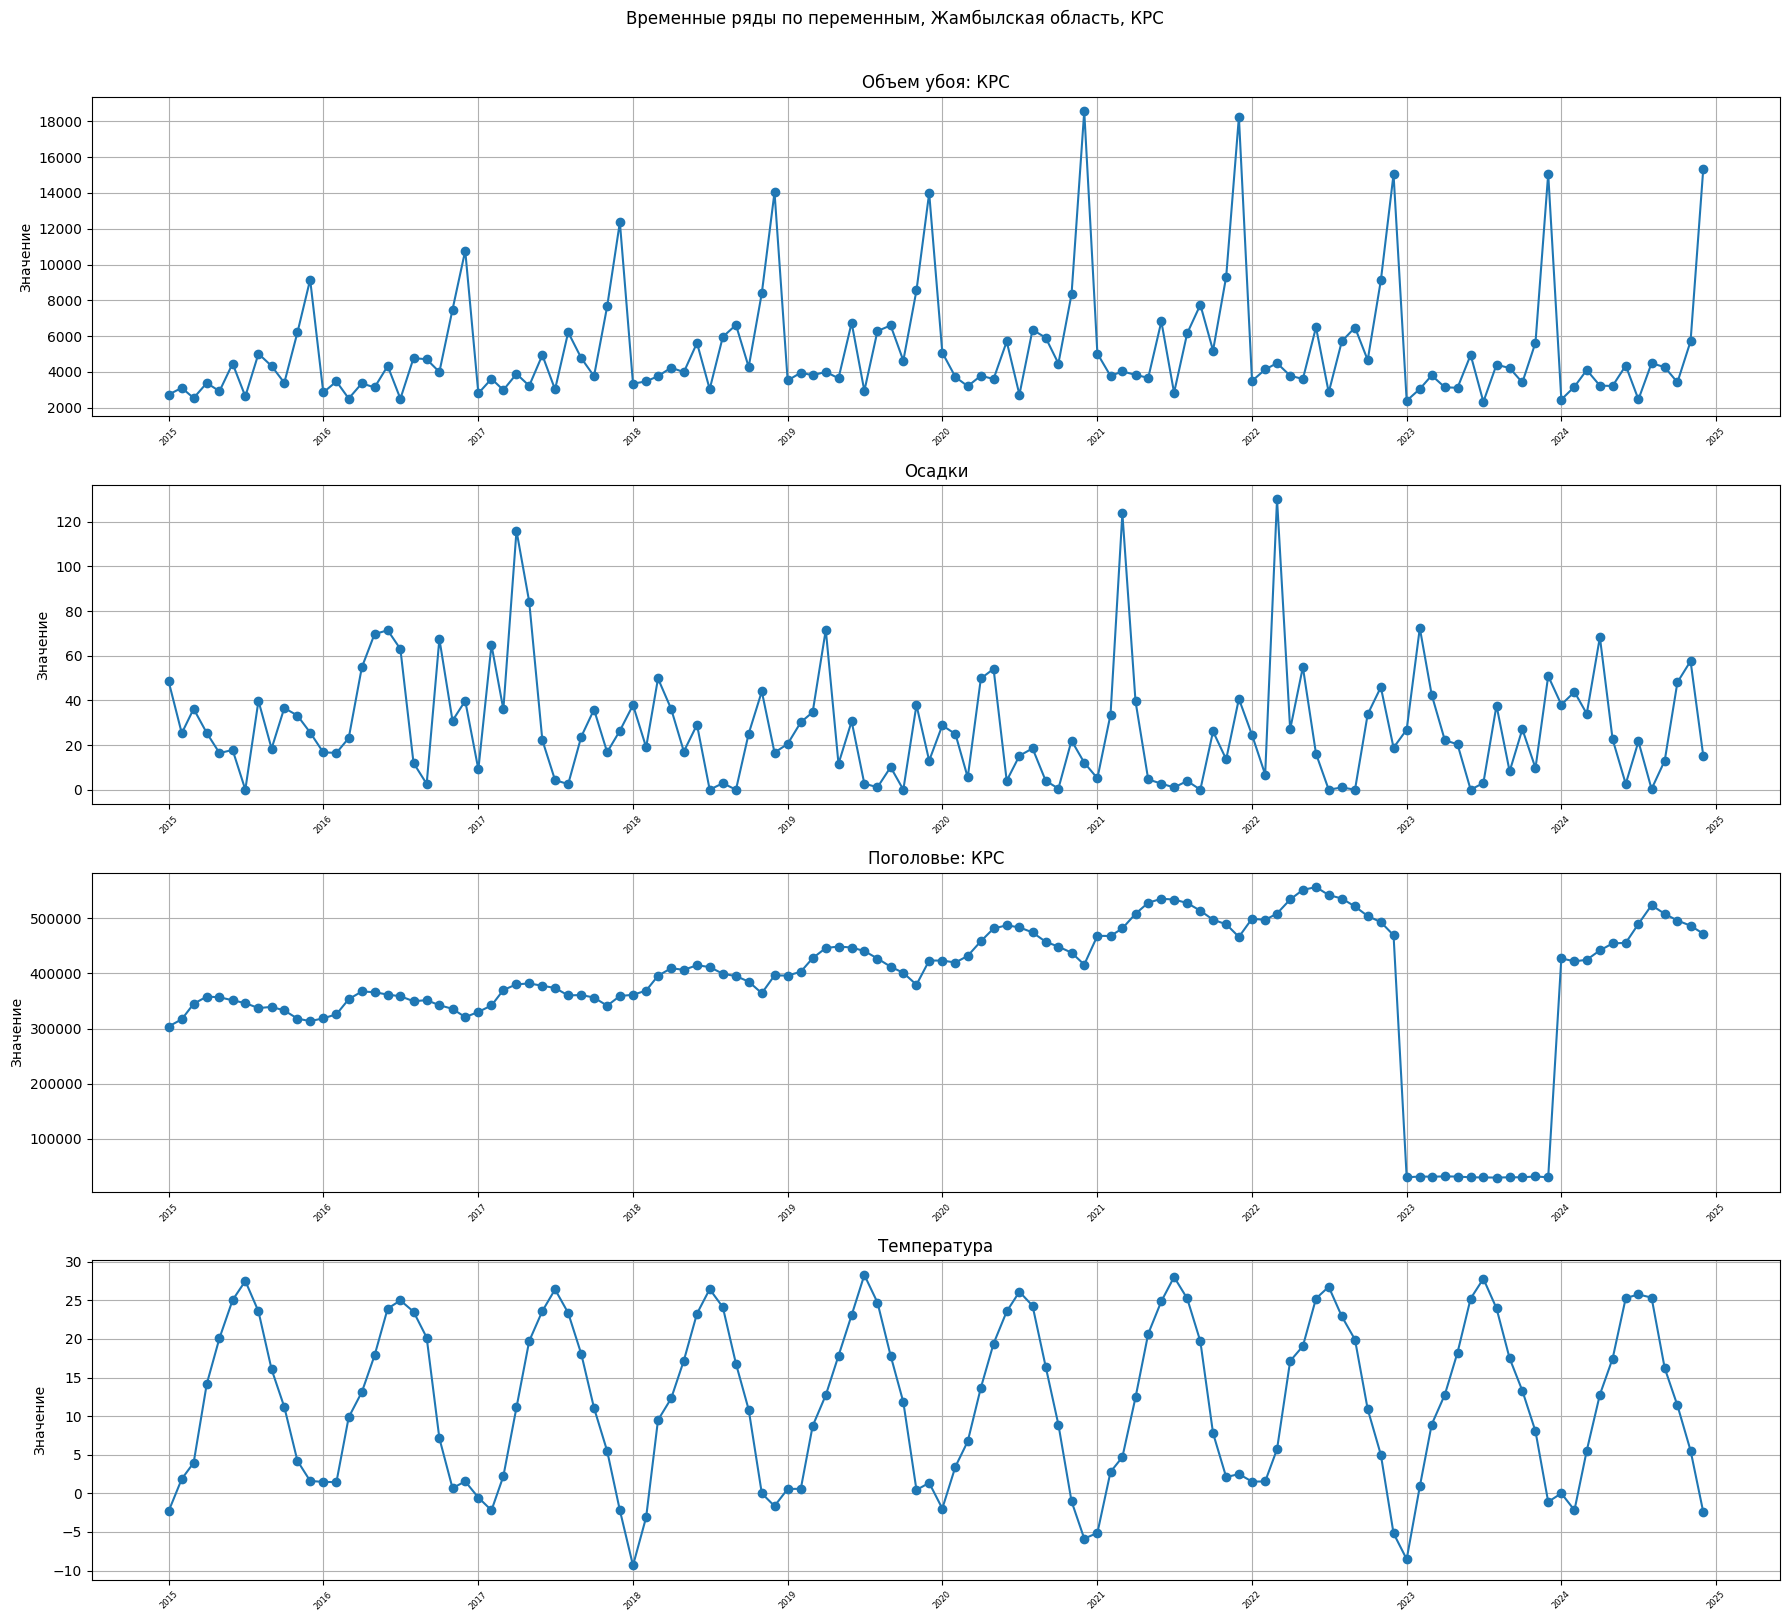

In [7]:
# Plot each variable in its own subplot
value_cols = [col for col in df_zhambyl.columns if col not in ["Период"]]

n = len(value_cols)
plt.figure(figsize=(18, 4 * n))

for i, col in enumerate(value_cols, 1):
    plt.subplot(n, 1, i)
    plt.plot(df_zhambyl["Период"], df_zhambyl[col], marker="o")
    plt.title(f"{col}")
    plt.grid(True)
    plt.ylabel("Значение")
    plt.xticks(rotation=45, fontsize = 6)

plt.suptitle("Временные ряды по переменным, Жамбылская область, КРС", y=1.01)
plt.tight_layout()
plt.show()

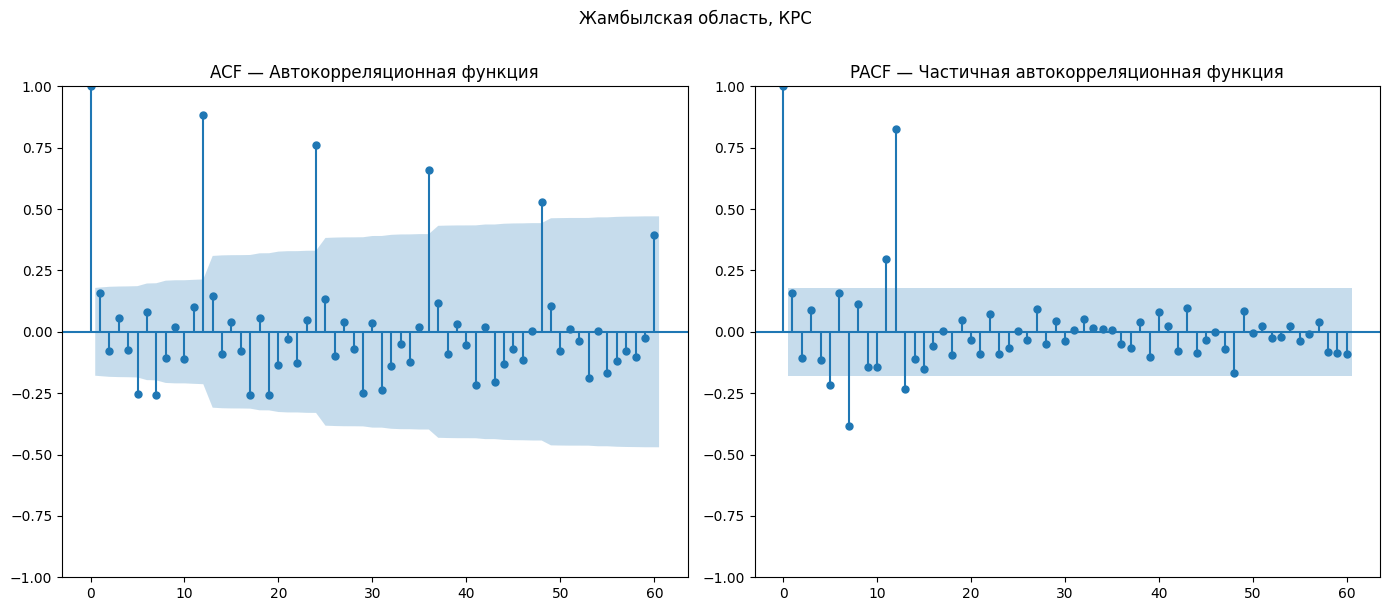

In [8]:
y = df_zhambyl["Объем убоя: КРС"].sort_index()

# Plot ACF and PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(y, lags=60, ax=plt.gca(), title="ACF — Автокорреляционная функция")

plt.subplot(1, 2, 2)
plot_pacf(y, lags=60, ax=plt.gca(), title="PACF — Частичная автокорреляционная функция", method="ywm")
plt.suptitle("Жамбылская область, КРС", y=1.01)

plt.tight_layout()
plt.show()

Графики автокорреляционной и частичной автокорреляционной функций указывают на возможную **годовую сезонность** (пики на +12, +24, +36 и +48 месяцев). 

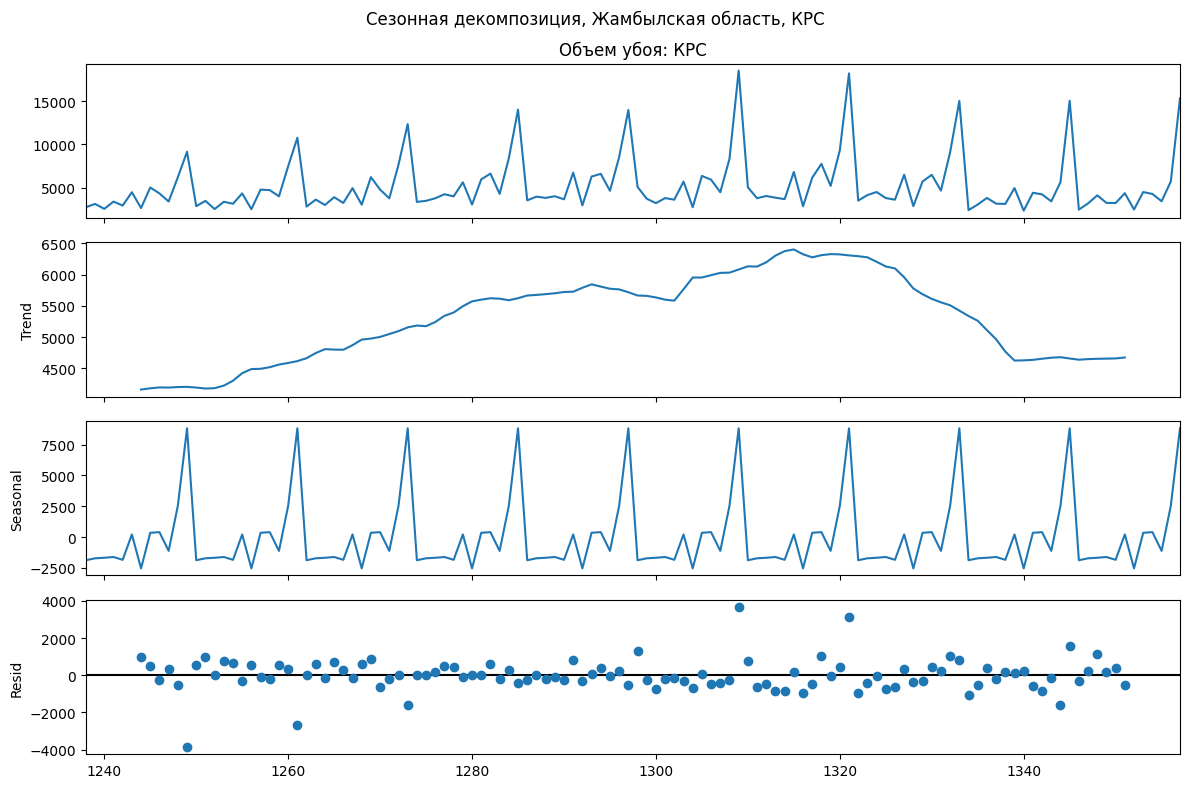

In [9]:
# Perform decomposition (period=12 for monthly data)
decomposition = seasonal_decompose(df_zhambyl["Объем убоя: КРС"], model="additive", period=12)

# Plot with larger figure size
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Сезонная декомпозиция, Жамбылская область, КРС", fontsize=12)
plt.tight_layout()
plt.show()


In [10]:
# Run ADF test
result = adfuller(df_zhambyl["Объем убоя: КРС"])

# Display results
print("📊 Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

# Interpretation
if result[1] < 0.05:
    print("✅ The series is likely **stationary** (reject H₀).")
else:
    print("❌ The series is likely **non-stationary** (fail to reject H₀).")


📊 Augmented Dickey-Fuller Test Results:
ADF Statistic: -1.3938
p-value: 0.5853
Critical Value (1%): -3.4936
Critical Value (5%): -2.8892
Critical Value (10%): -2.5815
❌ The series is likely **non-stationary** (fail to reject H₀).


Результаты теста ADF указывают на **нестационарность** временного ряда.

In [11]:
df_zhambyl

,Период,Объем убоя: КРС,Осадки,Поголовье: КРС,Температура
1238,2015-01-01,2731.22,48.5,303643.0,-2.306452
1239,2015-02-01,3109.06,25.3,316778.0,1.871429
1240,2015-03-01,2538.81,36.2,344717.0,3.958065
1241,2015-04-01,3379.88,25.4,357904.0,14.166667
1242,2015-05-01,2921.49,16.4,356641.0,20.106452
...,...,...,...,...,...
1353,2024-08-01,4488.08,0.3,523425.0,25.345161
1354,2024-09-01,4264.39,13.0,507738.0,16.213333
1355,2024-10-01,3418.05,48.1,495712.0,11.387097
1356,2024-11-01,5708.50,57.6,486310.0,5.546667


In [12]:
# Создание лагов t-1 до t-6 для переменных
for lag in range(1, 7):
    df_zhambyl[f"КРС_t-{lag}"] = df_zhambyl["Объем убоя: КРС"].shift(lag)
    df_zhambyl[f"Температура_t-{lag}"] = df_zhambyl["Температура"].shift(lag)
    df_zhambyl[f"Осадки_t-{lag}"] = df_zhambyl["Осадки"].shift(lag)
    df_zhambyl[f"Поголовье: КРС_t-{lag}"] = df_zhambyl["Поголовье: КРС"].shift(lag)

df_zhambyl_full = df_zhambyl[["Период", "Объем убоя: КРС", 
                            "КРС_t-1", "КРС_t-2", "КРС_t-3", "КРС_t-4", "КРС_t-5", "КРС_t-6",
                            "Температура", "Температура_t-1", "Температура_t-2", "Температура_t-3", "Температура_t-4", "Температура_t-5", "Температура_t-6",
                            "Осадки", "Осадки_t-1", "Осадки_t-2", "Осадки_t-3", "Осадки_t-4", "Осадки_t-5", "Осадки_t-6",
                            "Поголовье: КРС", "Поголовье: КРС_t-1", "Поголовье: КРС_t-2", "Поголовье: КРС_t-3", "Поголовье: КРС_t-4", "Поголовье: КРС_t-5", "Поголовье: КРС_t-6"]]
df_zhambyl_full

,Период,Объем убоя: КРС,КРС_t-1,КРС_t-2,КРС_t-3,КРС_t-4,КРС_t-5,КРС_t-6,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Температура_t-5,Температура_t-6,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Осадки_t-5,Осадки_t-6,Поголовье: КРС,Поголовье: КРС_t-1,Поголовье: КРС_t-2,Поголовье: КРС_t-3,Поголовье: КРС_t-4,Поголовье: КРС_t-5,Поголовье: КРС_t-6
1238,2015-01-01,2731.22,NaN,NaN,NaN,NaN,NaN,NaN,-2.306452,NaN,NaN,NaN,NaN,NaN,NaN,48.5,NaN,NaN,NaN,NaN,NaN,NaN,303643.0,NaN,NaN,NaN,NaN,NaN,NaN
1239,2015-02-01,3109.06,2731.22,NaN,NaN,NaN,NaN,NaN,1.871429,-2.306452,NaN,NaN,NaN,NaN,NaN,25.3,48.5,NaN,NaN,NaN,NaN,NaN,316778.0,303643.0,NaN,NaN,NaN,NaN,NaN
1240,2015-03-01,2538.81,3109.06,2731.22,NaN,NaN,NaN,NaN,3.958065,1.871429,-2.306452,NaN,NaN,NaN,NaN,36.2,25.3,48.5,NaN,NaN,NaN,NaN,344717.0,316778.0,303643.0,NaN,NaN,NaN,NaN
1241,2015-04-01,3379.88,2538.81,3109.06,2731.22,NaN,NaN,NaN,14.166667,3.958065,1.871429,-2.306452,NaN,NaN,NaN,25.4,36.2,25.3,48.5,NaN,NaN,NaN,357904.0,344717.0,316778.0,303643.0,NaN,NaN,NaN
1242,2015-05-01,2921.49,3379.88,2538.81,3109.06,2731.22,NaN,NaN,20.106452,14.166667,3.958065,1.871429,-2.306452,NaN,NaN,16.4,25.4,36.2,25.3,48.5,NaN,NaN,356641.0,357904.0,344717.0,316778.0,303643.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,2024-08-01,4488.08,2461.28,4352.03,3215.25,3231.51,4104.82,3173.15,25.345161,25.758065,25.286667,17.441935,12.786667,5.535484,-2.175862,0.3,21.6,2.6,22.6,68.3,34.0,43.8,523425.0,489551.0,455255.0,454158.0,441599.0,424527.0,421726.0
1354,2024-09-01,4264.39,4488.08,2461.28,4352.03,3215.25,3231.51,4104.82,16.213333,25.345161,25.758065,25.286667,17.441935,12.786667,5.535484,13.0,0.3,21.6,2.6,22.6,68.3,34.0,507738.0,523425.0,489551.0,455255.0,454158.0,441599.0,424527.0
1355,2024-10-01,3418.05,4264.39,4488.08,2461.28,4352.03,3215.25,3231.51,11.387097,16.213333,25.345161,25.758065,25.286667,17.441935,12.786667,48.1,13.0,0.3,21.6,2.6,22.6,68.3,495712.0,507738.0,523425.0,489551.0,455255.0,454158.0,441599.0
1356,2024-11-01,5708.50,3418.05,4264.39,4488.08,2461.28,4352.03,3215.25,5.546667,11.387097,16.213333,25.345161,25.758065,25.286667,17.441935,57.6,48.1,13.0,0.3,21.6,2.6,22.6,486310.0,495712.0,507738.0,523425.0,489551.0,455255.0,454158.0


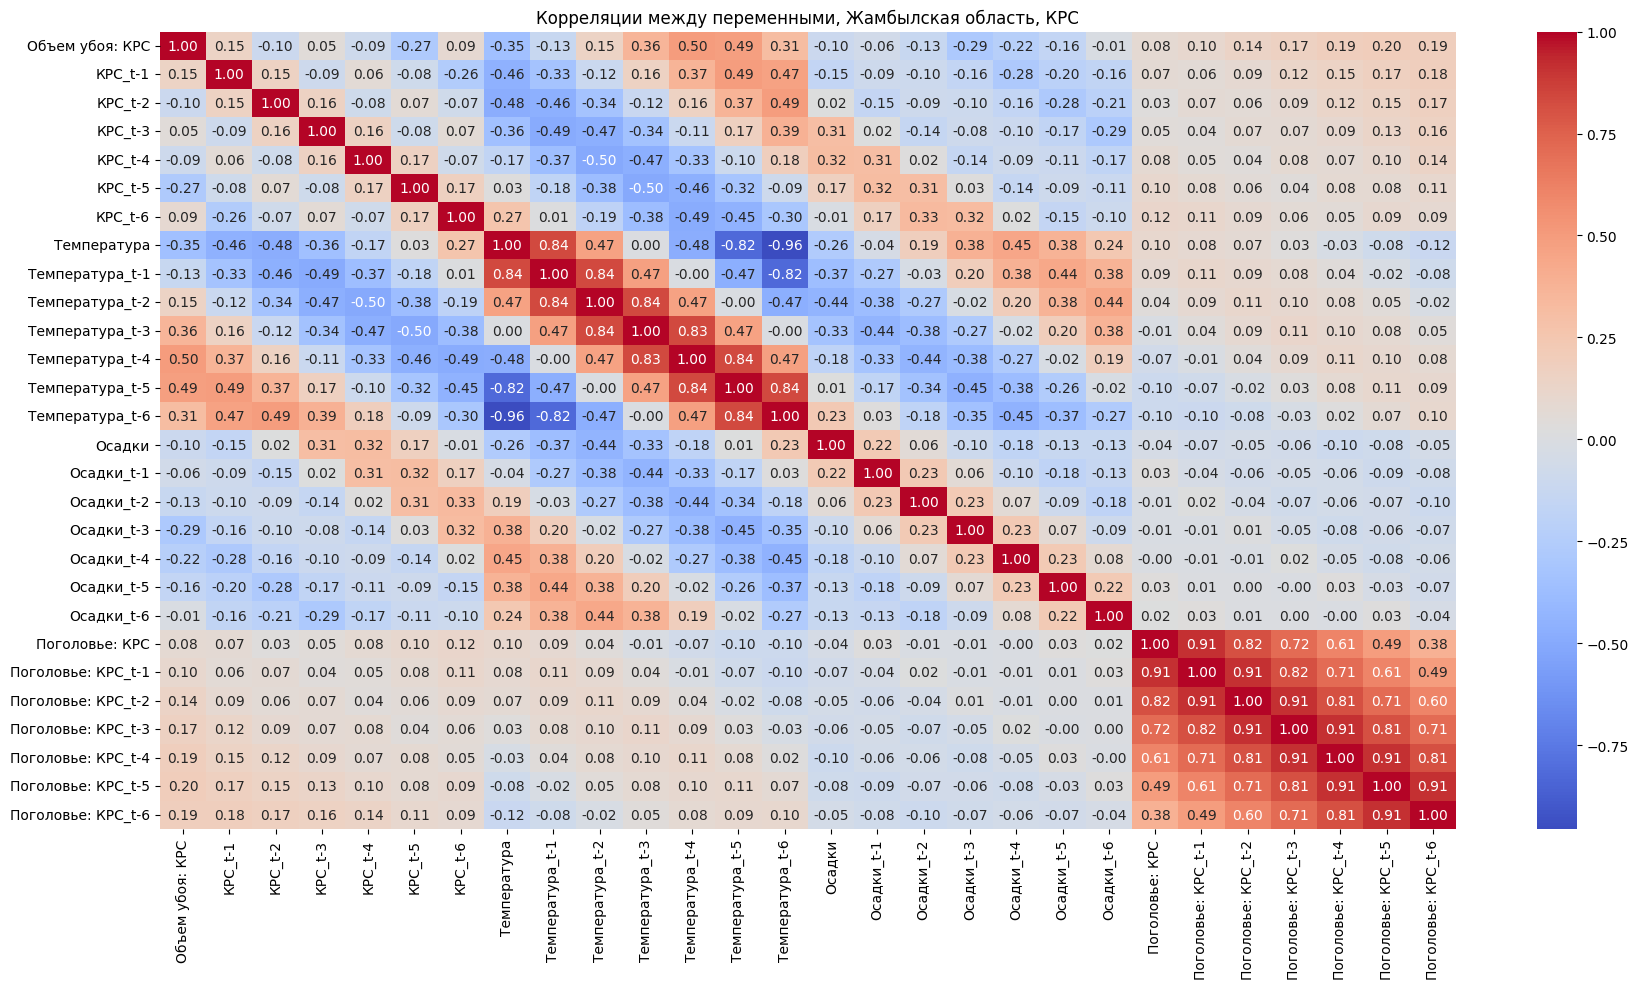

In [13]:
df_corr = df_zhambyl_full[[col for col in df_zhambyl_full.columns if col not in ["Период"]]].dropna().copy()

# 1. Correlation matrix
corr_matrix = df_corr.corr()

# 2. Plot heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляции между переменными, Жамбылская область, КРС")
plt.tight_layout()
plt.show()

*ВЫВОДЫ ПО КОРРЕЛЯЦИИ*

In [ ]:
# Set your target variable
target_var = "Объем убоя: КРС"

# Get correlations with the target variable
target_corr = corr_matrix[target_var].drop(target_var)  # exclude self-correlation

# Keep only features with |correlation| >= 0.5
selected_vars = target_corr[abs(target_corr) >= 0.49].index.tolist()

print("✅ Отобранные переменные с корреляцией >= 0.5:")
print(selected_vars)

# Optionally: create new dataframe with selected variables + target
df_selected = df_zhambyl_full[['Период'] + selected_vars + [target_var]]
df_selected

✅ Отобранные переменные с корреляцией >= 0.4:
['Температура_t-4']


,Период,Температура_t-4,Объем убоя: КРС
1238,2015-01-01,NaN,2731.22
1239,2015-02-01,NaN,3109.06
1240,2015-03-01,NaN,2538.81
1241,2015-04-01,NaN,3379.88
1242,2015-05-01,-2.306452,2921.49
...,...,...,...
1353,2024-08-01,12.786667,4488.08
1354,2024-09-01,17.441935,4264.39
1355,2024-10-01,25.286667,3418.05
1356,2024-11-01,25.758065,5708.50


In [28]:
df_vif = df_selected[[col for col in df_selected.columns if col not in ["Период"]]].dropna().copy()

X_vif = add_constant(df_vif[[i for i in df_vif.columns if i != "Объем убоя: КРС"]])

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_data.sort_values('VIF')

,Variable,VIF
1,Температура_t-4,1.000000
0,const,2.334576


Step-by-Step Strategy to Handle High VIFs:

Sort VIFs in descending order
Drop variables one at a time, starting with the one that has the highest VIF.

Check domain relevance
Keep variables that are theoretically important or core to your hypothesis, even if VIF is high.

Evaluate correlation matrix
If two variables have high correlation with each other, and both have high VIFs, drop the one less correlated with the target.

Recalculate VIF after each drop
After dropping one variable, recalculate all VIFs. Sometimes removing just one variable significantly reduces others.

Use stepwise selection (optional)
Automated methods like backward elimination can help drop redundant predictors based on model fit and VIF thresholds.

In [23]:
# df_selected = df_selected.drop(columns = ['Температура', 'Температура_t-2', 'Температура_t-3', 'Температура_t-6'])
df_selected

,Период,Температура_t-4,Температура_t-5,Объем убоя: КРС
1238,2015-01-01,NaN,NaN,2731.22
1239,2015-02-01,NaN,NaN,3109.06
1240,2015-03-01,NaN,NaN,2538.81
1241,2015-04-01,NaN,NaN,3379.88
1242,2015-05-01,-2.306452,NaN,2921.49
...,...,...,...,...
1353,2024-08-01,12.786667,5.535484,4488.08
1354,2024-09-01,17.441935,12.786667,4264.39
1355,2024-10-01,25.286667,17.441935,3418.05
1356,2024-11-01,25.758065,25.286667,5708.50


In [ ]:
# df_vif = df_selected[[col for col in df_selected.columns if col not in ["Период"]]].dropna().copy()
# X_vif = add_constant(df_vif[[i for i in df_vif.columns if i != "Объем убоя: КРС"]])

# vif_data = pd.DataFrame({
#     "Variable": X_vif.columns,
#     "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
# })
# vif_data.sort_values('VIF')

,Variable,VIF
0,const,2.463849
1,Температура_t-4,3.390255
2,Температура_t-5,3.390255


In [29]:
df_selected = df_selected.dropna().copy()
df_selected

,Период,Температура_t-4,Объем убоя: КРС
1242,2015-05-01,-2.306452,2921.49
1243,2015-06-01,1.871429,4463.86
1244,2015-07-01,3.958065,2630.68
1245,2015-08-01,14.166667,5015.59
1246,2015-09-01,20.106452,4328.26
...,...,...,...
1353,2024-08-01,12.786667,4488.08
1354,2024-09-01,17.441935,4264.39
1355,2024-10-01,25.286667,3418.05
1356,2024-11-01,25.758065,5708.50


### Models

#### Многофакторная регрессия

In [ ]:
# def forward_selection(data, target, candidate_features, criterion="adj_r2"):
#     remaining = list(candidate_features)
#     selected = []
#     best_score = -float("inf")
#     best_model = None

#     while remaining:
#         scores_with_candidates = []
#         for candidate in remaining:
#             features = selected + [candidate]
#             X = sm.add_constant(data[features])
#             y = data[target]
#             model = sm.OLS(y, X).fit()

#             if criterion == "adj_r2":
#                 score = model.rsquared_adj
#             elif criterion == "aic":
#                 score = -model.aic  # negative for maximizing
#             else:
#                 raise ValueError("criterion must be 'adj_r2' or 'aic'")

#             scores_with_candidates.append((score, candidate, model))

#         scores_with_candidates.sort(reverse=True)
#         best_new_score, best_candidate, model = scores_with_candidates[0]

#         if best_new_score > best_score:
#             remaining.remove(best_candidate)
#             selected.append(best_candidate)
#             best_score = best_new_score
#             best_model = model
#             print(f"✅ Added: {best_candidate}, {criterion.upper()}: {best_score:.4f}")
#         else:
#             print("⛔ No improvement. Stopping.")
#             break

#     return selected, best_model


In [31]:
# Define target and features
y = df_selected["Объем убоя: КРС"]
X = df_selected.drop(columns=["Период", "Объем убоя: КРС"])

# Add constant term
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Show summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Объем убоя: КРС   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     38.48
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           9.14e-09
Time:                        19:40:33   Log-Likelihood:                -1085.6
No. Observations:                 116   AIC:                             2175.
Df Residuals:                     114   BIC:                             2181.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3429.5767    401.608     

In [32]:
df_selected

,Период,Температура_t-4,Объем убоя: КРС
1242,2015-05-01,-2.306452,2921.49
1243,2015-06-01,1.871429,4463.86
1244,2015-07-01,3.958065,2630.68
1245,2015-08-01,14.166667,5015.59
1246,2015-09-01,20.106452,4328.26
...,...,...,...
1353,2024-08-01,12.786667,4488.08
1354,2024-09-01,17.441935,4264.39
1355,2024-10-01,25.286667,3418.05
1356,2024-11-01,25.758065,5708.50


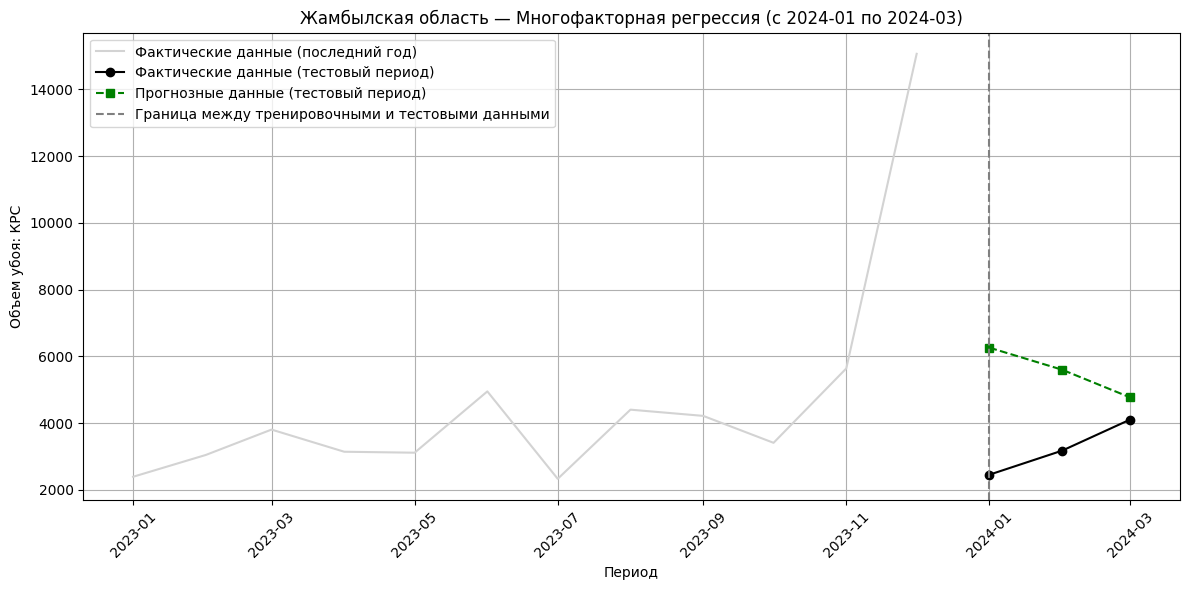

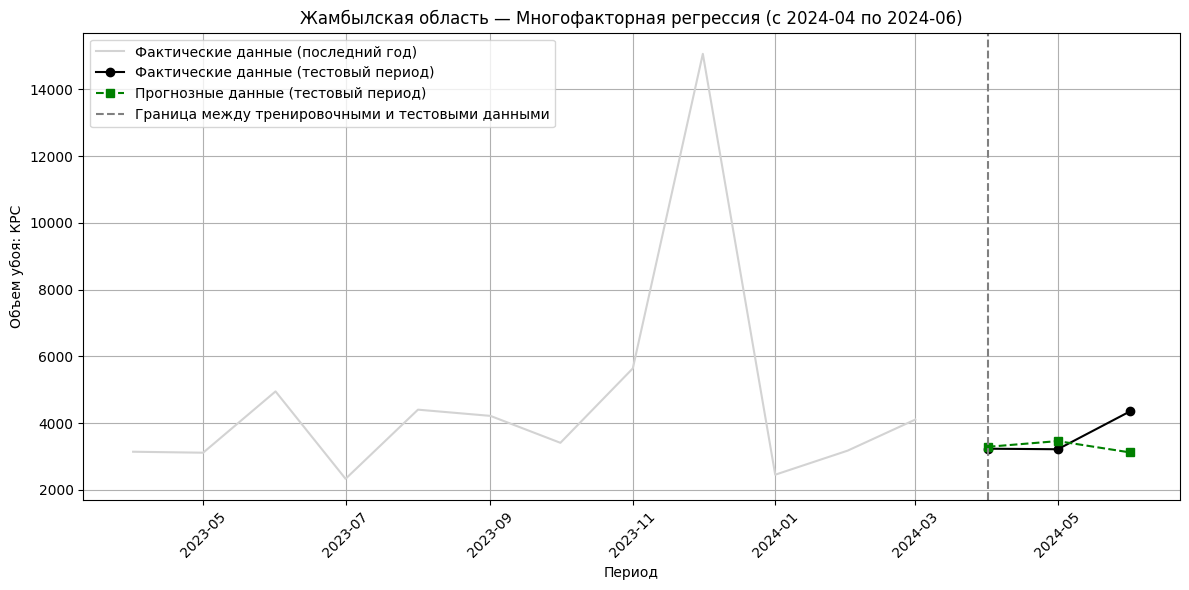

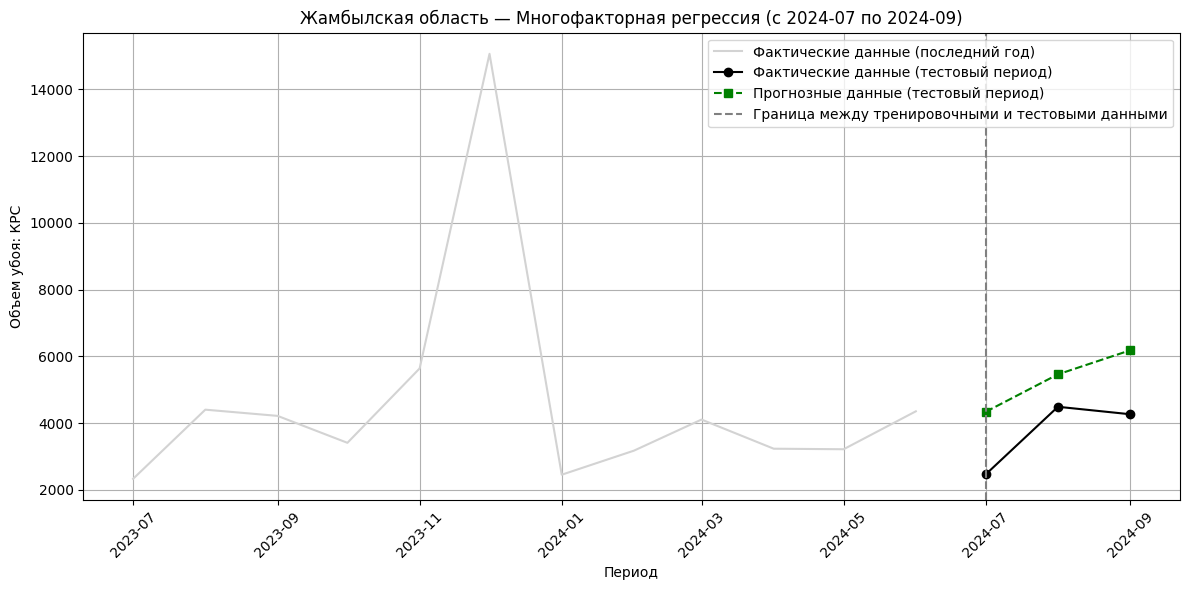

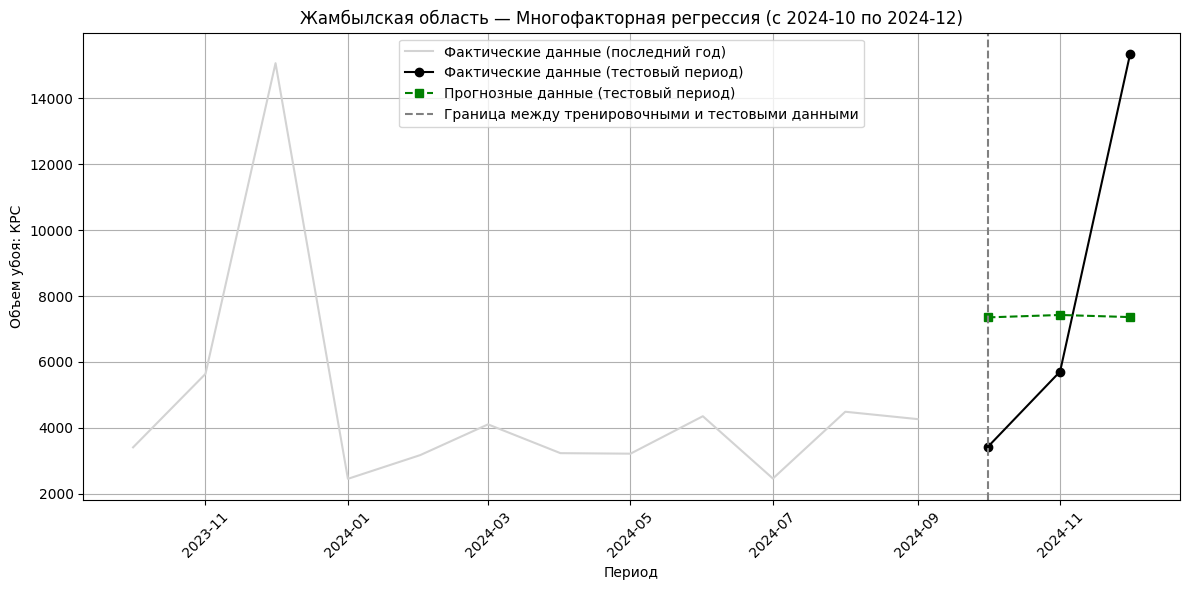

In [33]:
df = df_selected.sort_values("Период").copy()

target = "Объем убоя: КРС"
features = [col for col in df_selected.columns if col not in ['Период', 'Объем убоя: КРС']]

results = []

# Define 4 rolling test sets for 2024
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    X_train = sm.add_constant(train_df[features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        # "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Жамбылская область — Многофакторная регрессия (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [34]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period         RMSE          MAE   MAPE (%)
0  2024-01 to 2024-03  2634.374614  2298.991552  82.623864
1  2024-04 to 2024-06   726.297790   511.234113  12.559139
2  2024-07 to 2024-09  1646.763681  1587.989216  47.602481
3  2024-10 to 2024-12  5236.345478  4546.676214  65.735415
4             Average  2560.945391  2236.222774  52.130225


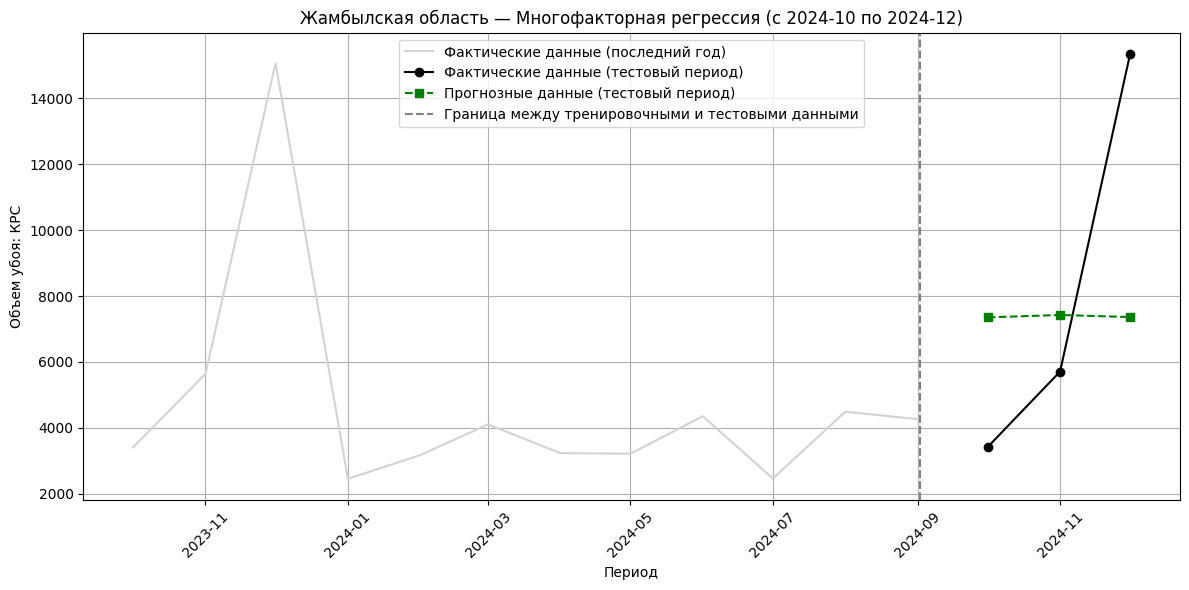

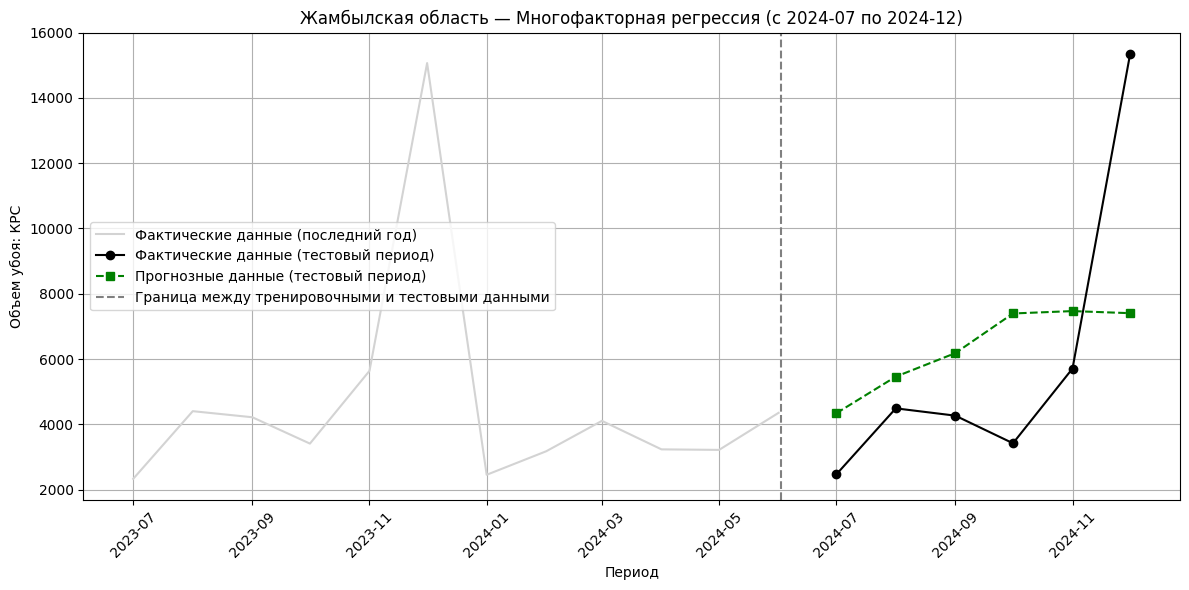

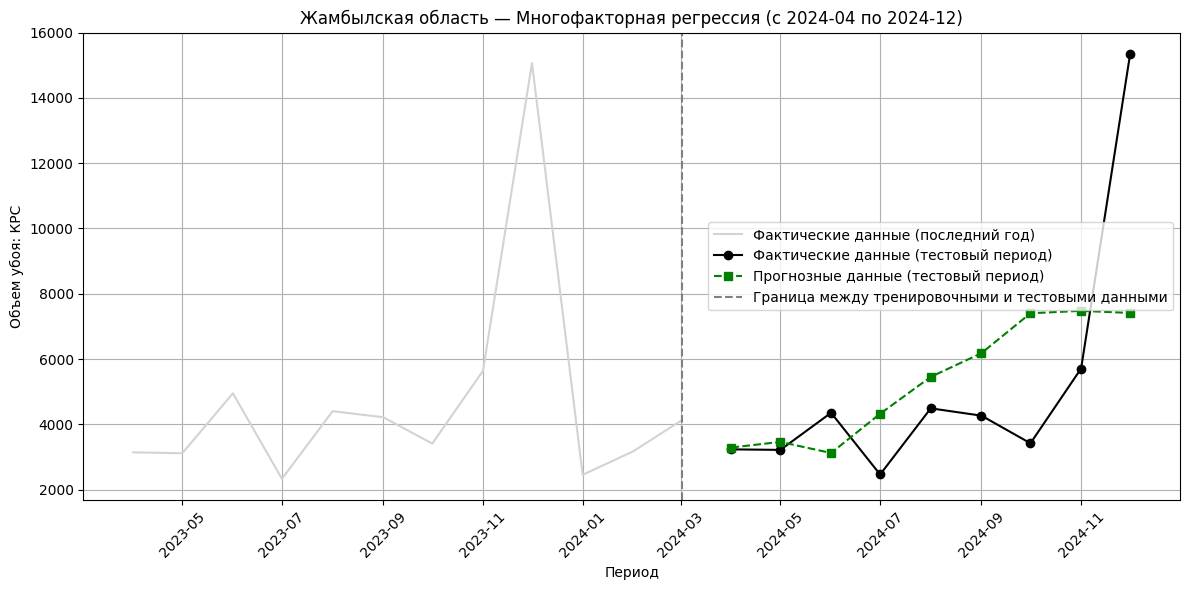

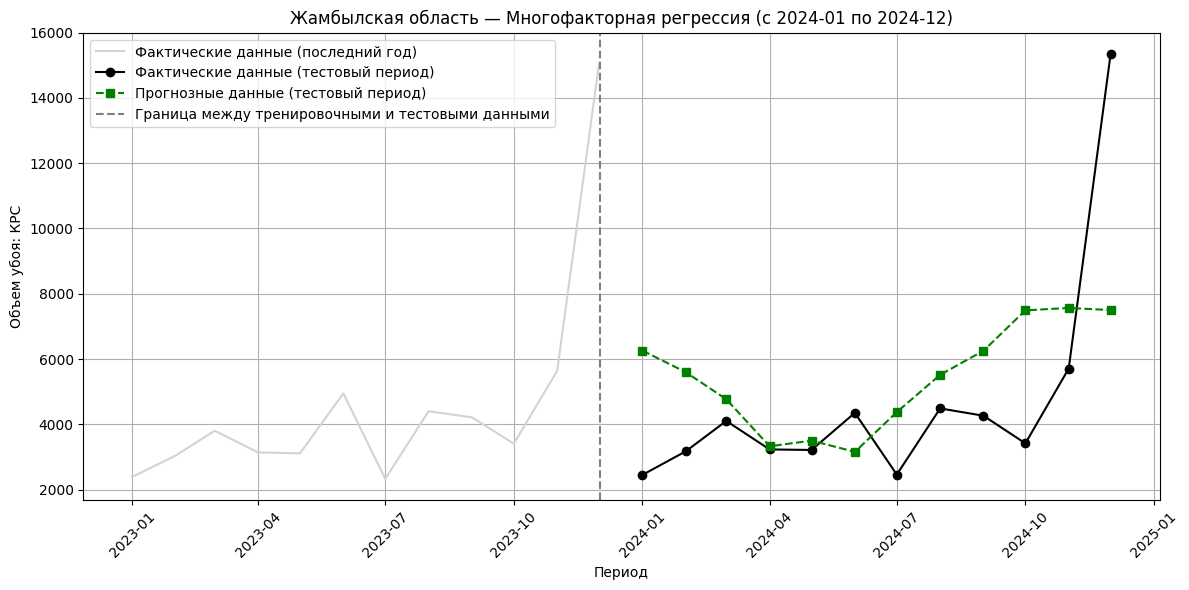

In [35]:
results = []

# Define 4 rolling test sets for 2024
horizons = [3, 6, 9, 12]

for horizon in horizons:

    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    X_train = sm.add_constant(train_df[features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        # "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Жамбылская область — Многофакторная регрессия (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [36]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period         RMSE          MAE   MAPE (%)
0  2024-10 to 2024-12  5236.345478  4546.676214  65.735415
1  2024-07 to 2024-12  3877.224375  3074.527685  56.958512
2  2024-04 to 2024-12  3191.502628  2218.223430  42.099315
3  2024-01 to 2024-12  3064.335465  2265.699122  53.116877
4             Average  3842.351987  3026.281613  54.477530


#### SARIMA (auto-arima)

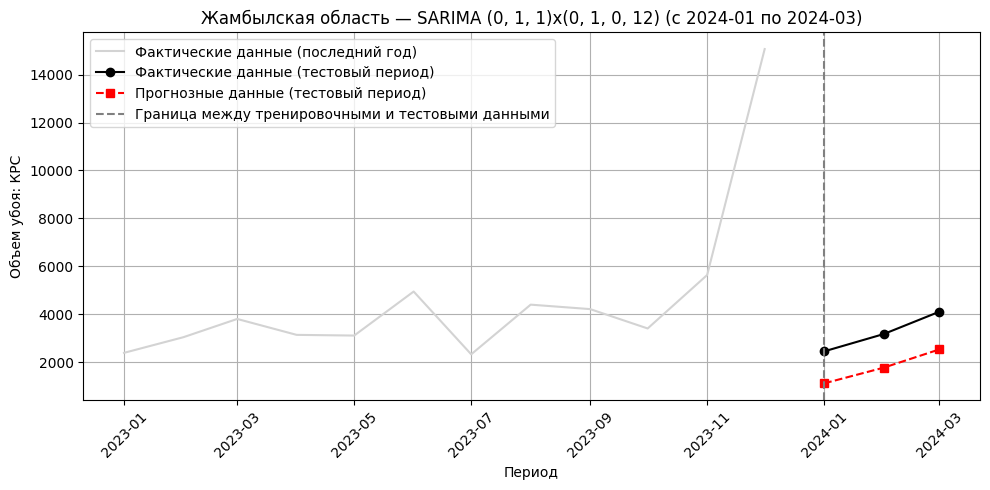

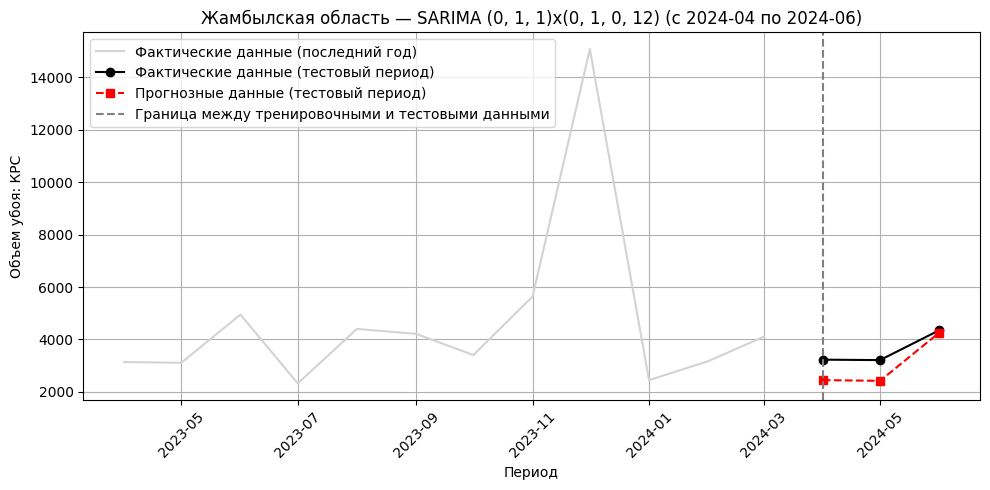

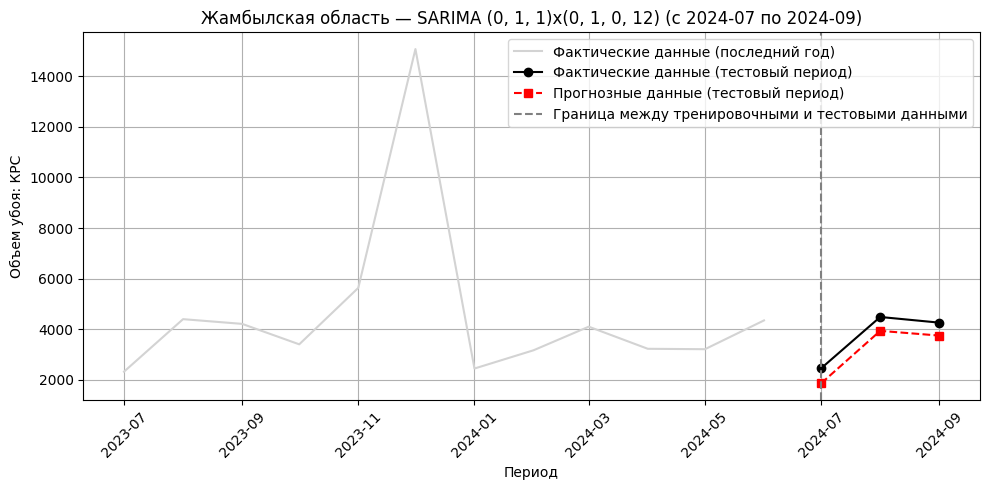

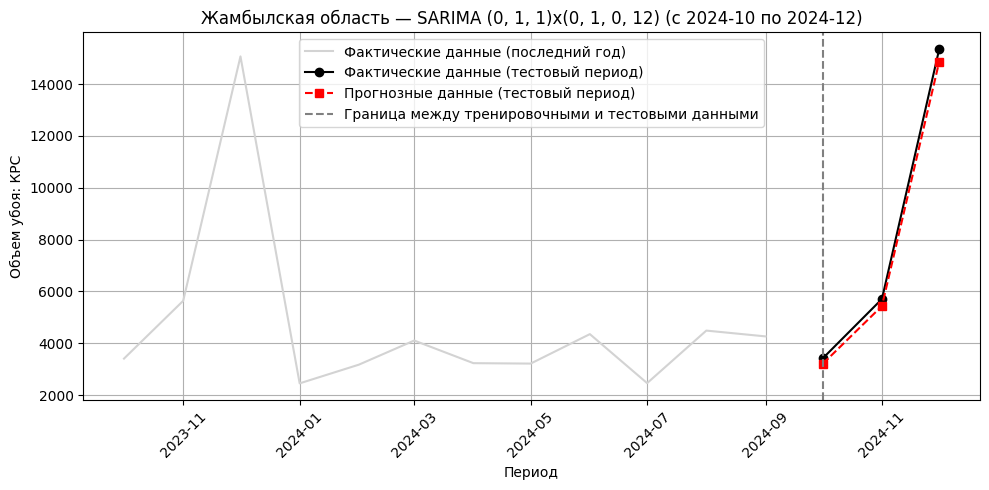

In [37]:
results = []

# Определим 4 тестовых периода на 3 месяца
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Разделим данные
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=3)
        forecast = pd.Series(forecast).reset_index(drop=True)


        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Жамбылская область — SARIMA {model.order}x{model.seasonal_order} (с {test_start.strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        # print("Zero values in y_test:", (y_test == 0).sum())


    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [38]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period         RMSE          MAE   MAPE (%) SARIMA order  \
0  2024-01 to 2024-03  1440.235810  1436.741592  45.649705    (0, 1, 1)   
1  2024-04 to 2024-06   642.785754   553.236452  16.921046    (0, 1, 1)   
2  2024-07 to 2024-09   552.324527   551.265401  16.117770    (0, 1, 1)   
3  2024-10 to 2024-12   342.563735   321.785717   4.683379    (0, 1, 1)   
4             Average   744.477456   715.757290  20.842975          NaN   

  Seasonal order  
0  (0, 1, 0, 12)  
1  (0, 1, 0, 12)  
2  (0, 1, 0, 12)  
3  (0, 1, 0, 12)  
4            NaN  


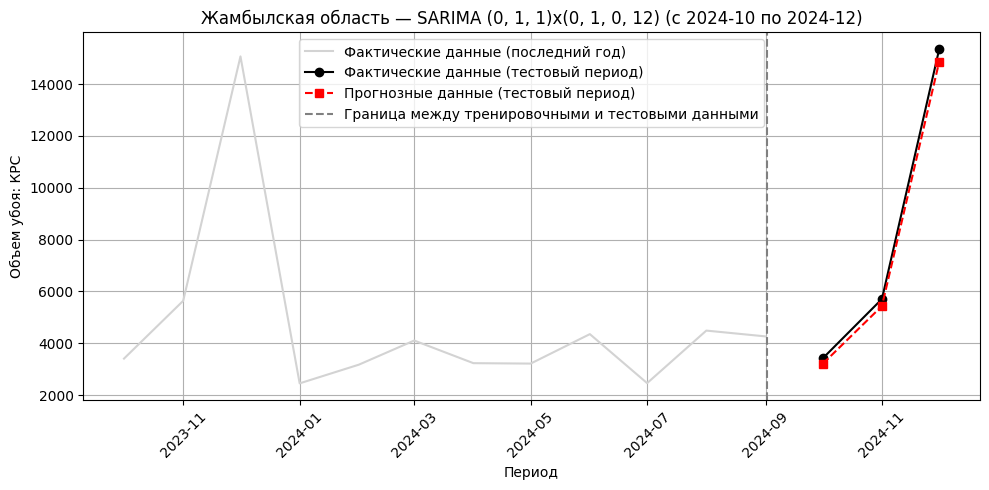

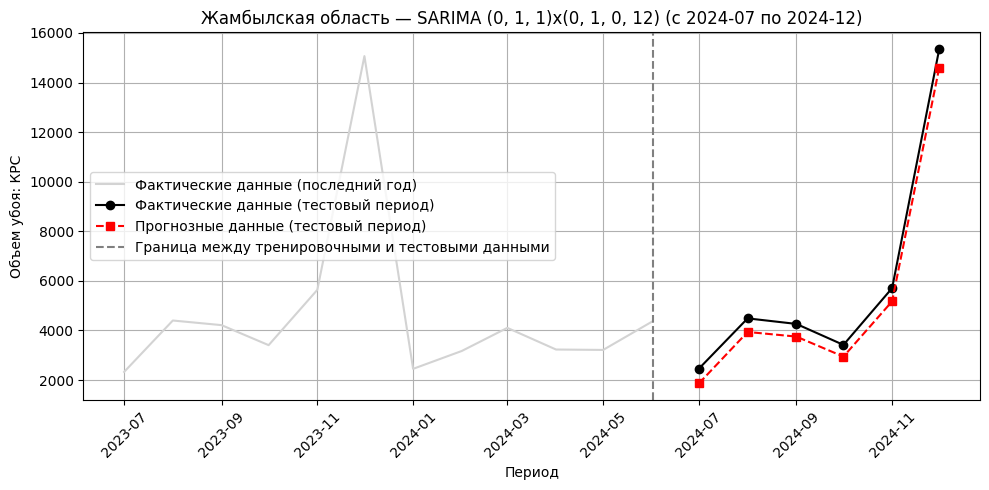

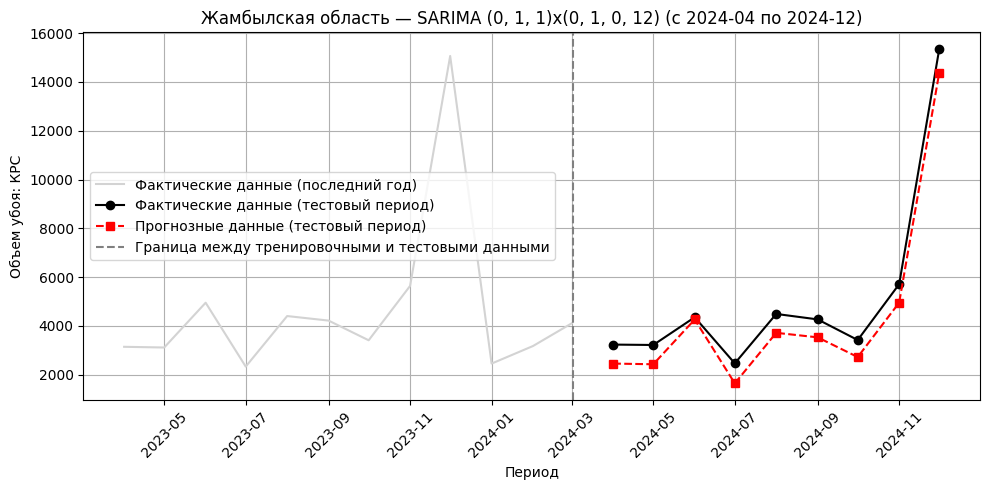

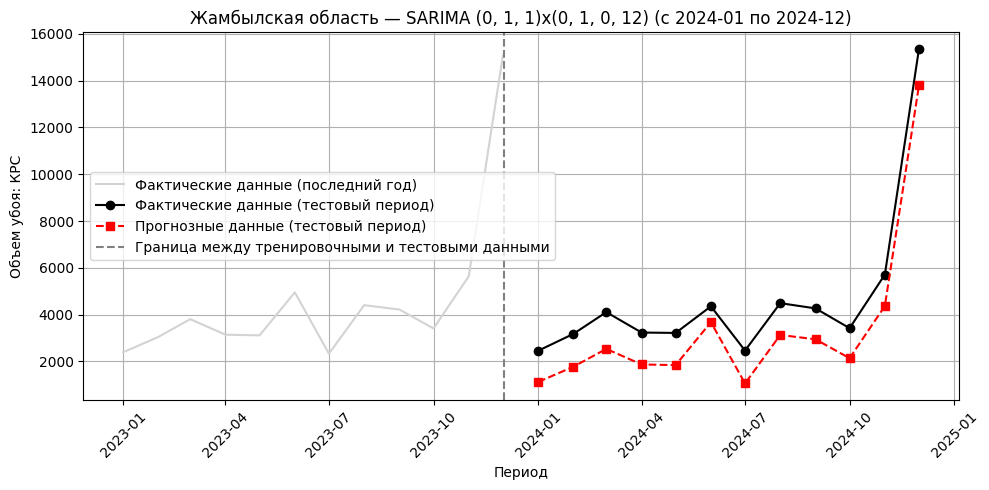

In [39]:
results = []

horizons = [3, 6, 9, 12]

for horizon in horizons:

    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)
    
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=horizon)
        forecast = pd.Series(forecast).reset_index(drop=True)

        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Жамбылская область — SARIMA {model.order}x{model.seasonal_order} (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [41]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period         RMSE          MAE   MAPE (%) SARIMA order  \
0  2024-10 to 2024-12   342.563735   321.785717   4.683379    (0, 1, 1)   
1  2024-07 to 2024-12   574.267607   567.480401  12.726704    (0, 1, 1)   
2  2024-04 to 2024-12   749.634722   712.970897  17.621595    (0, 1, 1)   
3  2024-01 to 2024-12  1350.459325  1333.204925  35.594989    (0, 1, 1)   
4             Average   754.231347   733.860485  17.656667          NaN   

  Seasonal order  
0  (0, 1, 0, 12)  
1  (0, 1, 0, 12)  
2  (0, 1, 0, 12)  
3  (0, 1, 0, 12)  
4            NaN  


#### SARIMAX

In [ ]:
results = []

start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[features].reset_index(drop=True)
    exog_test = test_df[features].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(0, 1, 1),
            seasonal_order=(0, 1, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=3, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Жамбылская область — SARIMAX (с {start} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [ ]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)



In [ ]:
results = []

horizons = [3, 6, 9, 12]

for horizon in horizons:
    # test_start = pd.to_datetime(start)
    # test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[features].reset_index(drop=True)
    exog_test = test_df[features].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(0, 1, 1),
            seasonal_order=(0, 1, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=horizon, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Жамбылская область — SARIMAX (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [ ]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)

#### Prophet

19:45:49 - cmdstanpy - INFO - Chain [1] start processing
19:45:49 - cmdstanpy - INFO - Chain [1] done processing


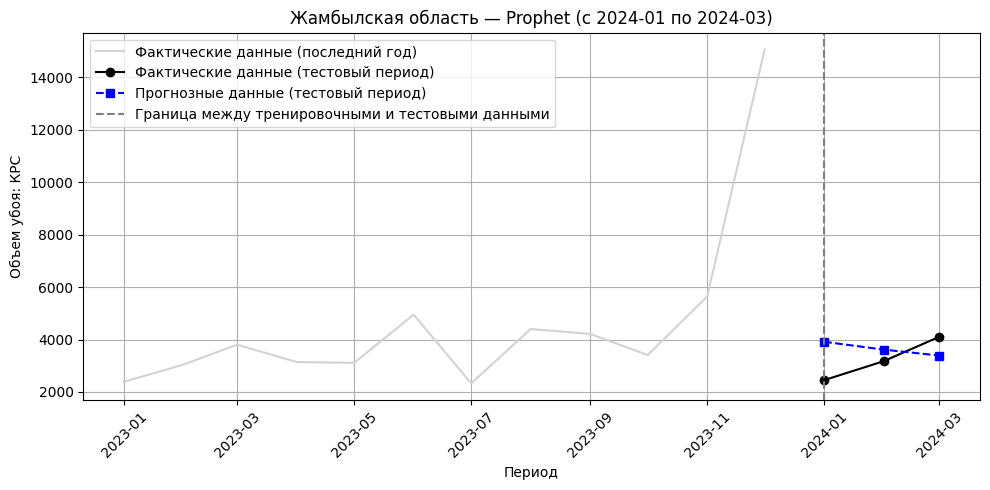

19:45:50 - cmdstanpy - INFO - Chain [1] start processing
19:45:50 - cmdstanpy - INFO - Chain [1] done processing


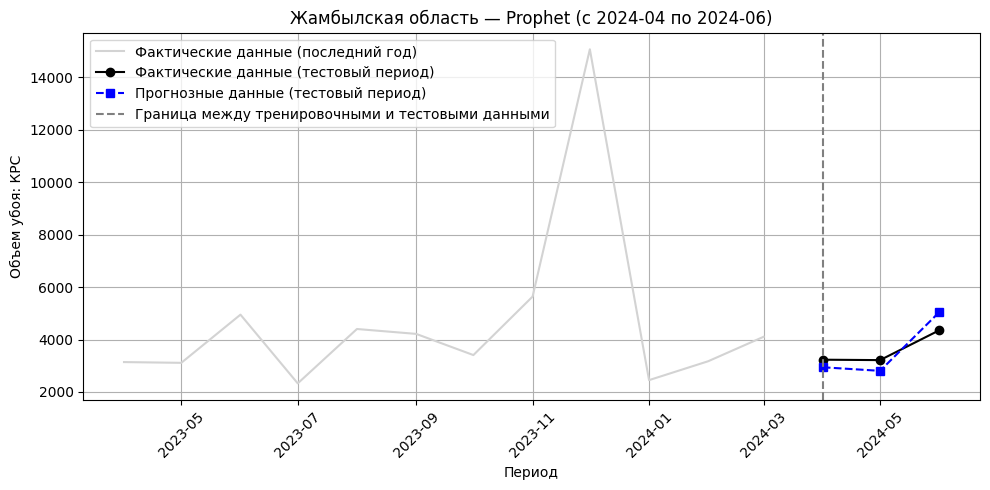

19:45:50 - cmdstanpy - INFO - Chain [1] start processing
19:45:50 - cmdstanpy - INFO - Chain [1] done processing


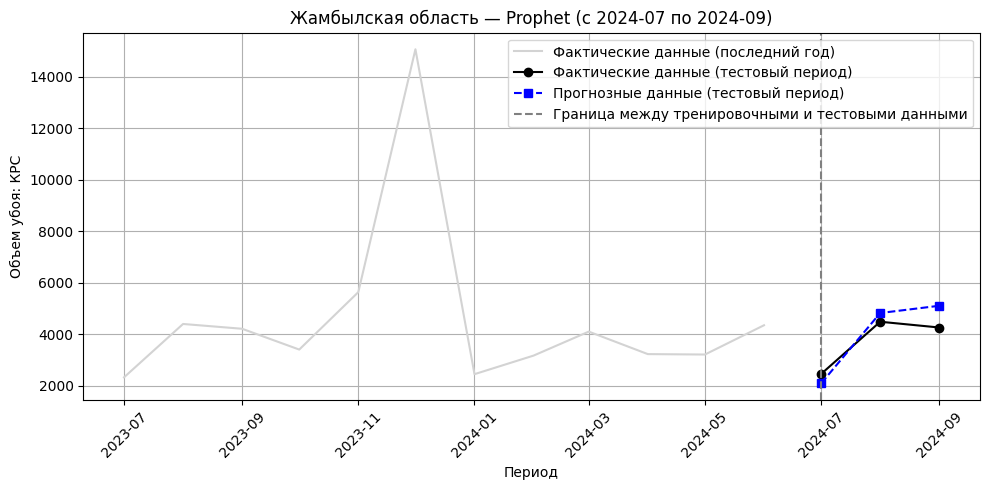

19:45:51 - cmdstanpy - INFO - Chain [1] start processing
19:45:51 - cmdstanpy - INFO - Chain [1] done processing


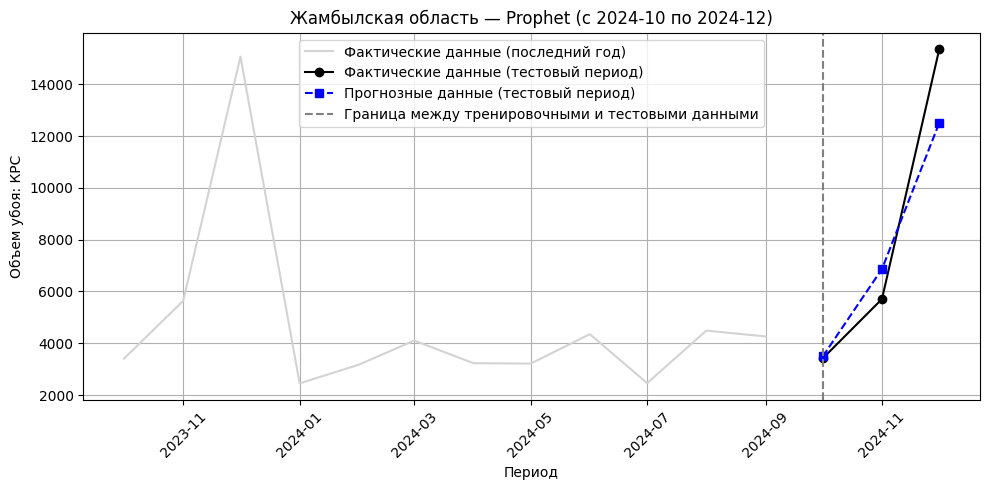

In [46]:
results = []

# Define 4 test periods
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Train/test split
    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Initialize Prophet
    model = Prophet()

    # Optional: add regressors
    # model.add_regressor("Температура_t-1")
    # prophet_train["Температура_t-1"] = train_df["Температура_t-1"].values
    # prophet_test["Температура_t-1"] = test_df["Температура_t-1"].values

    # Fit
    model.fit(prophet_train)

    # Create future dataframe
    future = model.make_future_dataframe(periods=3, freq="M")
    forecast = model.predict(future)
# forecast
# prophet_test

    # Extract forecast for test period only
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Жамбылская область — Prophet (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [47]:
results_df = pd.DataFrame(results)
avg = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg])], ignore_index=True)
print(results_df)

          Test period         RMSE          MAE   MAPE (%)
0  2024-01 to 2024-03   974.233500   873.681452  30.343860
1  2024-04 to 2024-06   492.752050   463.001294  12.513063
2  2024-07 to 2024-09   565.723519   515.994924  14.063369
3  2024-10 to 2024-12  1774.548580  1359.706004  13.673356
4             Average   951.814412   803.095918  17.648412


19:46:04 - cmdstanpy - INFO - Chain [1] start processing
19:46:04 - cmdstanpy - INFO - Chain [1] done processing


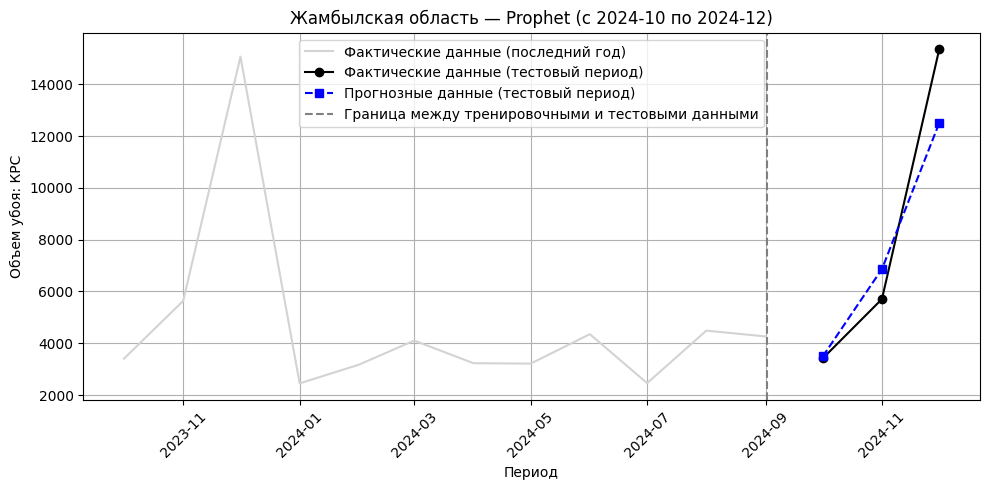

19:46:04 - cmdstanpy - INFO - Chain [1] start processing
19:46:04 - cmdstanpy - INFO - Chain [1] done processing


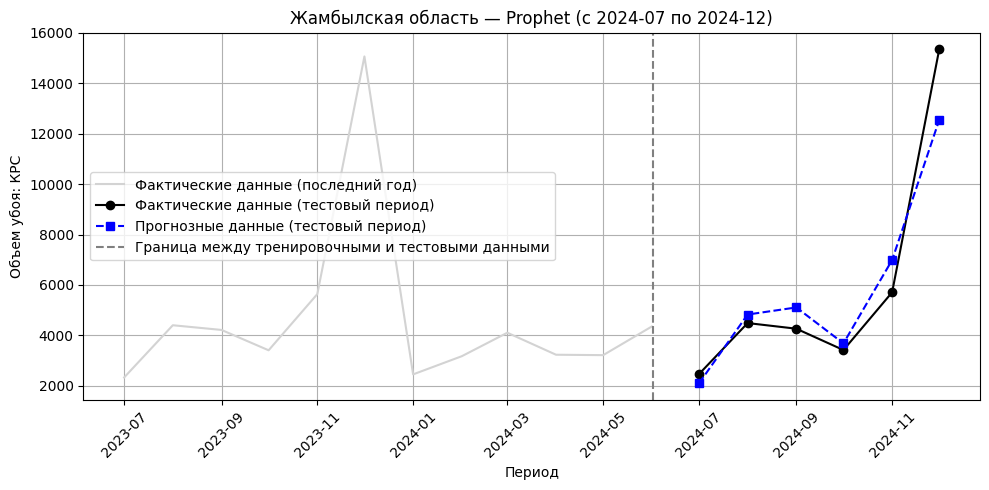

19:46:05 - cmdstanpy - INFO - Chain [1] start processing
19:46:05 - cmdstanpy - INFO - Chain [1] done processing


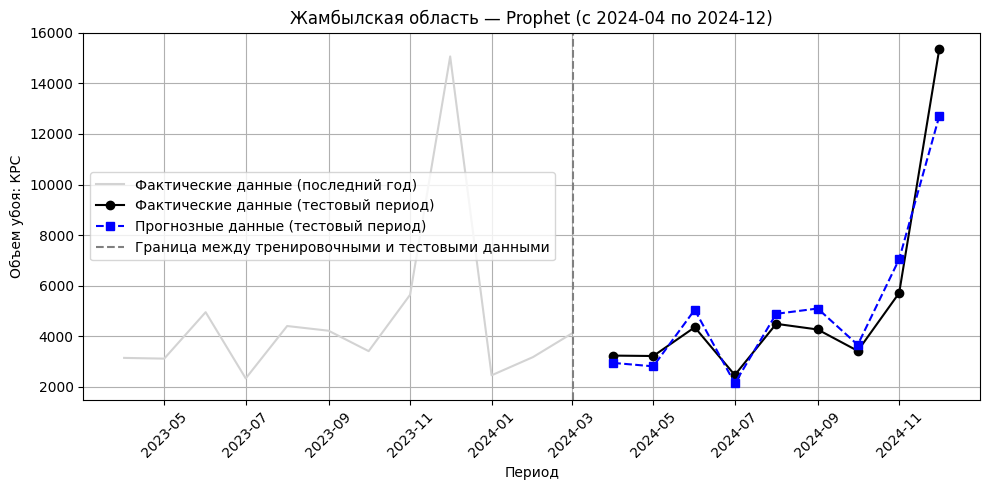

19:46:05 - cmdstanpy - INFO - Chain [1] start processing
19:46:05 - cmdstanpy - INFO - Chain [1] done processing


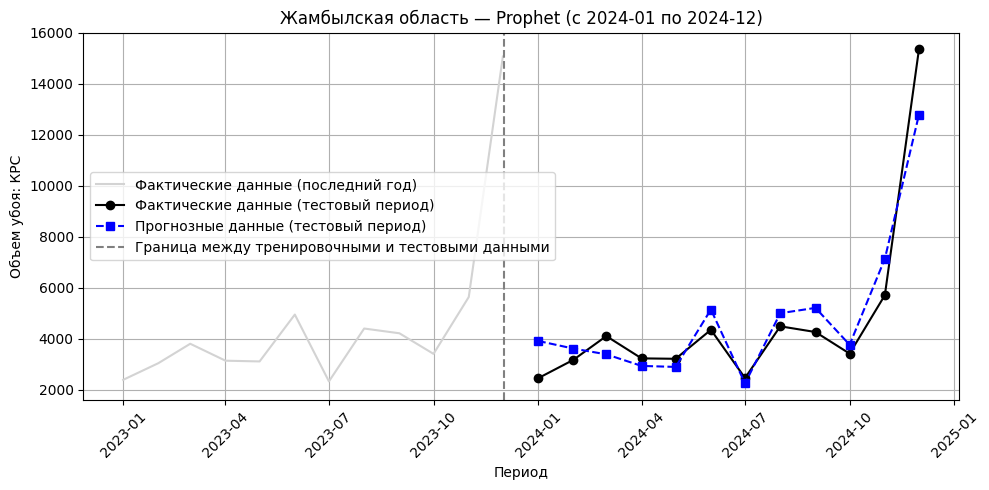

In [48]:
horizons = [3, 6, 9, 12]
results = []

for horizon in horizons:

    # Define train/test split
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Fit Prophet
    model = Prophet()
    model.fit(prophet_train)

    # Forecast
    future = model.make_future_dataframe(periods=horizon, freq="M")
    forecast = model.predict(future)

    # Extract matching forecasted months
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Жамбылская область — Prophet (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [49]:
# Summary table
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)

          Test period         RMSE          MAE   MAPE (%)
0  2024-10 to 2024-12  1774.548580  1359.706004  13.673356
1  2024-07 to 2024-12  1323.978347   982.326683  15.099313
2  2024-04 to 2024-12  1081.993379   796.204117  14.088501
3  2024-01 to 2024-12  1064.875242   837.024124  18.548259
4                 NaN  1311.348887   993.815232  15.352357


strength of correlation:
https://link.springer.com/article/10.1057/jt.2009.5#
https://resources.nu.edu/statsresources/correlation